AYU SUKMAWATI SAJIDA (202255202002)

In [2]:
%pip install ultralytics
!pip install roboflow
!pip install deep-sort-realtime
import ultralytics
ultralytics.checks()

Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.7/112.6 GB disk)


In [3]:
from ultralytics import YOLO

# model YOLOv8n
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 88.6MB/s]


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="8deicVcMv7SGsDuoCVfn")
project = rf.workspace("tugas-5-deeplearning").project("perhitungan-yolo-dompet")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Perhitungan-yolo-dompet-2 in yolov8:: 100%|██████████| 782/782 [00:00<00:00, 7224.04it/s]


In [5]:
# Training
!yolo task=detect mode=train model=yolov8n.pt data=Perhitungan-yolo-dompet-2/data.yaml epochs=50 imgsz=640

Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Perhitungan-yolo-dompet-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

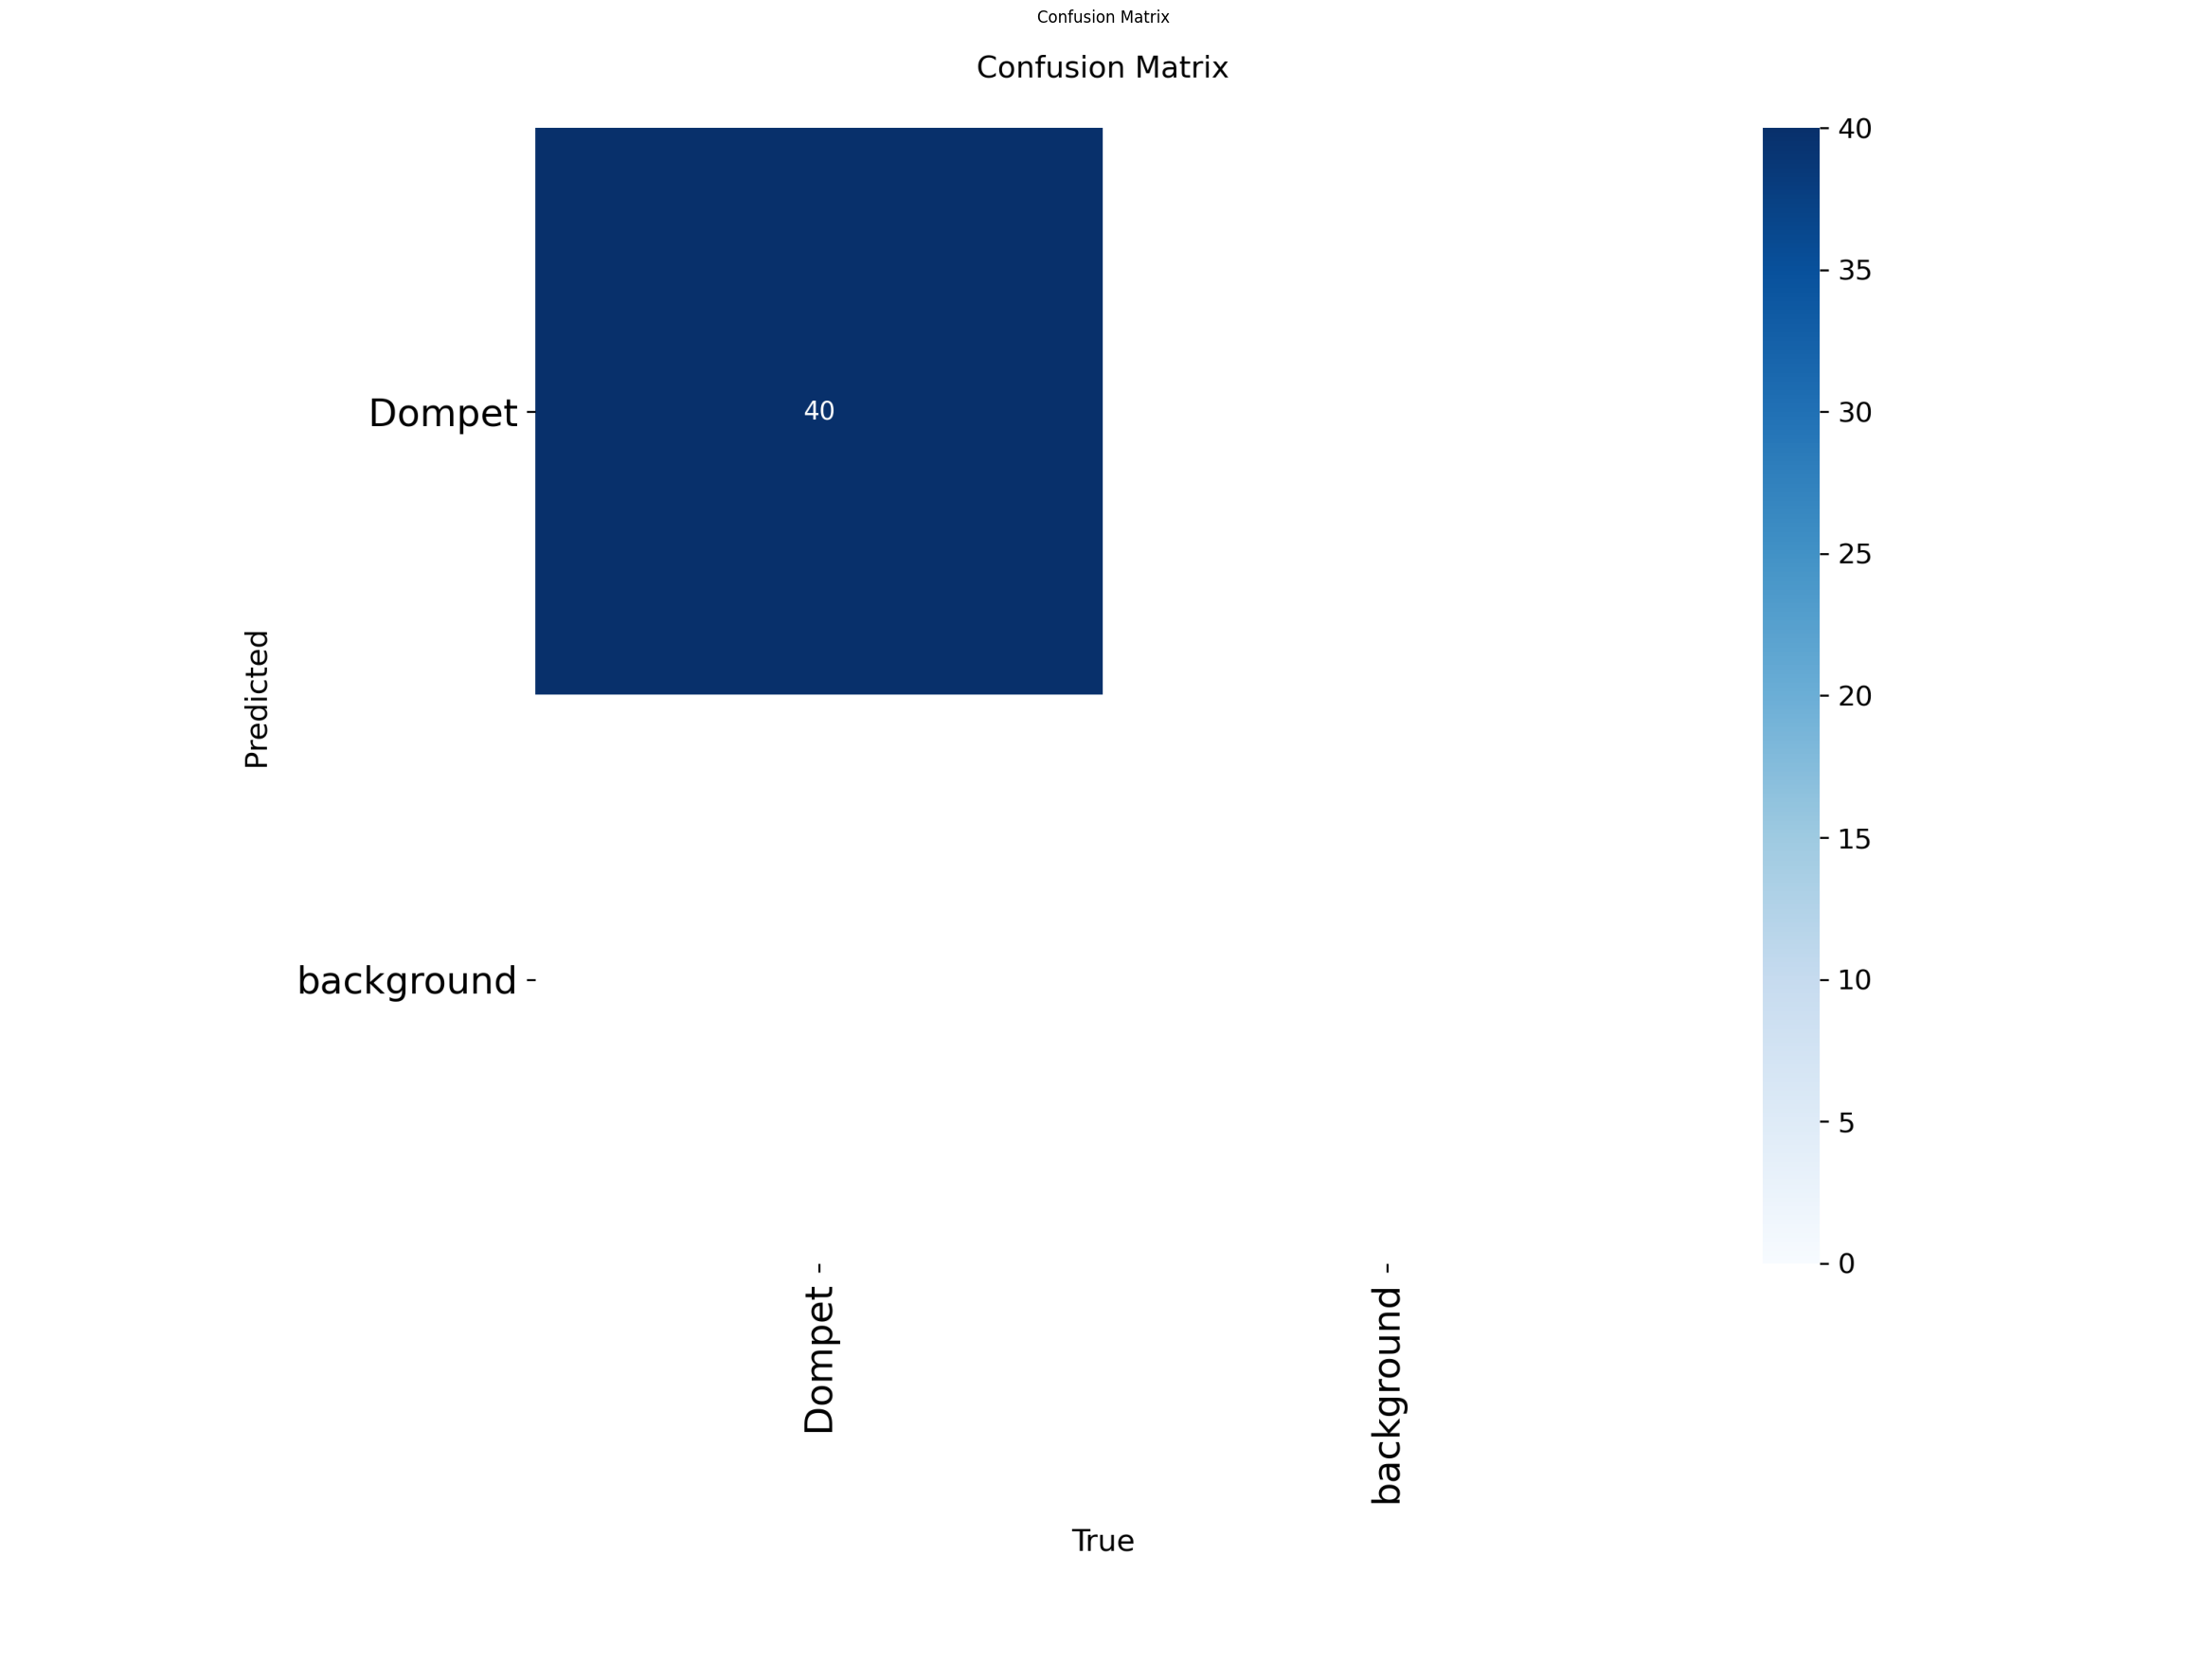

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/content/runs/detect/train/confusion_matrix.png"
img = Image.open(img_path)

w, h = img.size
dpi = 100

plt.figure(figsize=(w/dpi, h/dpi), dpi=dpi)
plt.imshow(img)
plt.axis('off')
plt.title("Confusion Matrix", fontsize=12)
plt.show()

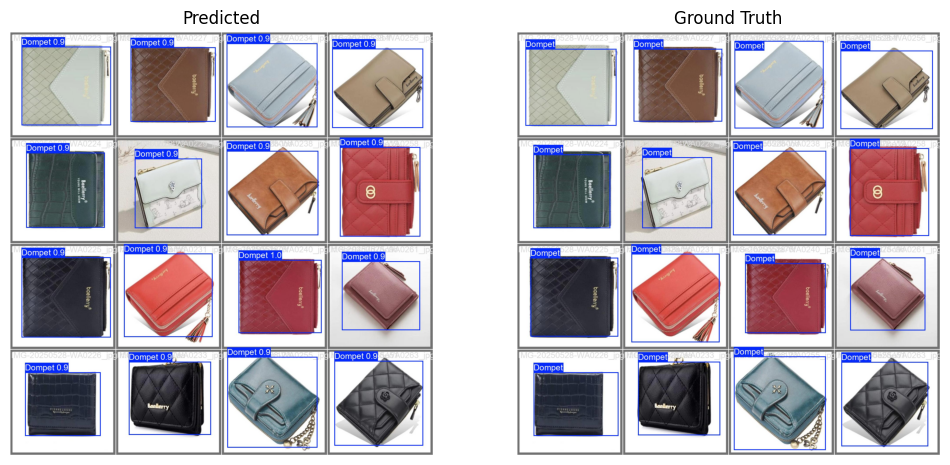

In [7]:
pred = Image.open("runs/detect/train/val_batch0_pred.jpg")
labels = Image.open("runs/detect/train/val_batch0_labels.jpg")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(pred)
plt.axis('off')
plt.title("Predicted")

plt.subplot(1, 2, 2)
plt.imshow(labels)
plt.axis('off')
plt.title("Ground Truth")

plt.show()

In [8]:
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import numpy as np
from datetime import datetime

In [9]:
!pip install ultralytics opencv-python

In [11]:
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import numpy as np
from datetime import datetime

def is_crossing_line(p1, p2, line_y):
    return (p1[1] < line_y and p2[1] >= line_y) or (p1[1] > line_y and p2[1] <= line_y)

# Load model dompet
model = YOLO("runs/detect/train/weights/best.pt")  # pastikan model mengenali 'dompet'

# Daftar video
video_pairs = [
    ("video dompet.mp4", "output_dompet.mp4")
]

for video_input, video_output in video_pairs:
    tracker = DeepSort(
        max_age=30,
        n_init=3,
        max_iou_distance=0.7,
        embedder="mobilenet",
        half=True,
        bgr=True
    )

    cap = cv2.VideoCapture(video_input)
    w, h, fps = int(cap.get(3)), int(cap.get(4)), cap.get(5)

    out = cv2.VideoWriter(video_output,
                          cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

    # Garis bantu horizontal
    line_y = int(h / 2)
    counted_ids = set()
    previous_centroids = {}

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, conf=0.4, iou=0.5, imgsz=640)[0]
        detections = []

        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            label = model.names[cls]
            if label.lower() != "dompet":
                continue
            detections.append(([x1, y1, x2 - x1, y2 - y1], conf, "dompet"))

        tracks = tracker.update_tracks(detections, frame=frame)

        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            l, t, r, b = track.to_ltrb()
            cx = int((l + r) / 2)
            cy = int((t + b) / 2)

            # Periksa apakah melintasi garis
            previous = previous_centroids.get(track_id)
            if previous and is_crossing_line(previous, (cx, cy), line_y):
                if track_id not in counted_ids:
                    counted_ids.add(track_id)

            previous_centroids[track_id] = (cx, cy)

            label_text = f"{track_id}: dompet"
            cv2.rectangle(frame, (int(l), int(t)), (int(r), int(b)), (0, 255, 0), 2)
            cv2.putText(frame, label_text, (int(l), int(t) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Gambar garis bantu horizontal
        cv2.line(frame, (0, line_y), (w, line_y), (255, 0, 0), 2)

        # Hitungan dompet
        count_text = f"Jumlah Dompet: {len(counted_ids)}"
        cv2.putText(frame, count_text, (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)

        # Timestamp
        now = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        cv2.putText(frame, now, (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                    (255, 255, 255), 2)

        out.write(frame)

    cap.release()
    out.release()



0: 640x384 3 Dompets, 70.8ms
Speed: 3.7ms preprocess, 70.8ms inference, 203.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 Dompets, 11.7ms
Speed: 3.6ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 Dompets, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 Dompets, 25.7ms
Speed: 2.7ms preprocess, 25.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 Dompets, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 Dompets, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 Dompets, 6.3ms
Speed: 2.5ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 Dompets, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3